### Import Libraries

In [78]:
# data wrangling libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,RobustScaler,StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


### I. Project Background

#### **A. Dataset Introduction**  
1. **Source**: *Diabetes 130-US Hospitals for Years 1999-2008* (UCI Machine Learning Repository).  
2. **Contents**:  
   - **Main data**: 101,766 diabetic inpatient records (130 US hospitals, 1999–2008).  
   - **Supplementary data**: Mappings for categorical IDs (e.g., admission types).  

#### **B. Dataset Scope**  
The data was extracted from database with the following criteria:
1. It is an inpatient encounter (a hospital admission).
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered into the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

#### **C. Project Objective**  
**Goal**: Develop classification model to predict whether the diabetic patient would be readmitted < 30 days, > 30 days using:
- Clinical features (`HbA1c`, medications, prior hospitalizations),  
- Supervised learning.

### II. Data Exploration

#### a. Data Loading

In [23]:
# read data
diabetes_data = pd.read_csv("diabetes_dataset/diabetic_data.csv")

# show data information
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

#### b. Descriptive Statistics
- get the central tendency (mean/mode/median), standard deviation, data count, skewness, kurtosis.

In [24]:
# for object
diabetes_data.describe(include='object')

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,5346,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,3,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,Norm,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,2597,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [25]:
# for numeric
diabetes_data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


#### c. Data Distribution Analysis
- distribution visualization, outlier checking

##### i. Categorical Data Visualization

In [26]:
# show data distribution for categorical data
def categorical_distribution(df):
    low_cardinality_var = []
    categorical_cols = df.select_dtypes("object").columns
    for col in categorical_cols:
        if df[col].nunique() <= 10:
            low_cardinality_var.append(col)
            
    # create plot dimension
    total_rows = int(len(low_cardinality_var)/2)
    total_cols = 2
    fig, axes = plt.subplots(total_rows,total_cols,figsize=(15,4*total_rows))
    axes = axes.flatten()
    
    for i,low_car in enumerate(low_cardinality_var):
        plot_dataset = df.groupby(low_car).size().reset_index()
        plot_dataset = plot_dataset.rename(columns={0:"total"})
        sns.barplot(plot_dataset,x=low_car,y='total',ax=axes[i],color='darkseagreen')
        axes[i].set_title(f'Distribution of {low_car.title()}',fontsize=15)
        axes[i].tick_params(axis='x', rotation=15)
        axes[i].set_xlabel(low_car.title(), fontsize=14)
        axes[i].set_ylabel('Count', fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        
    plt.tight_layout()
    plt.show()

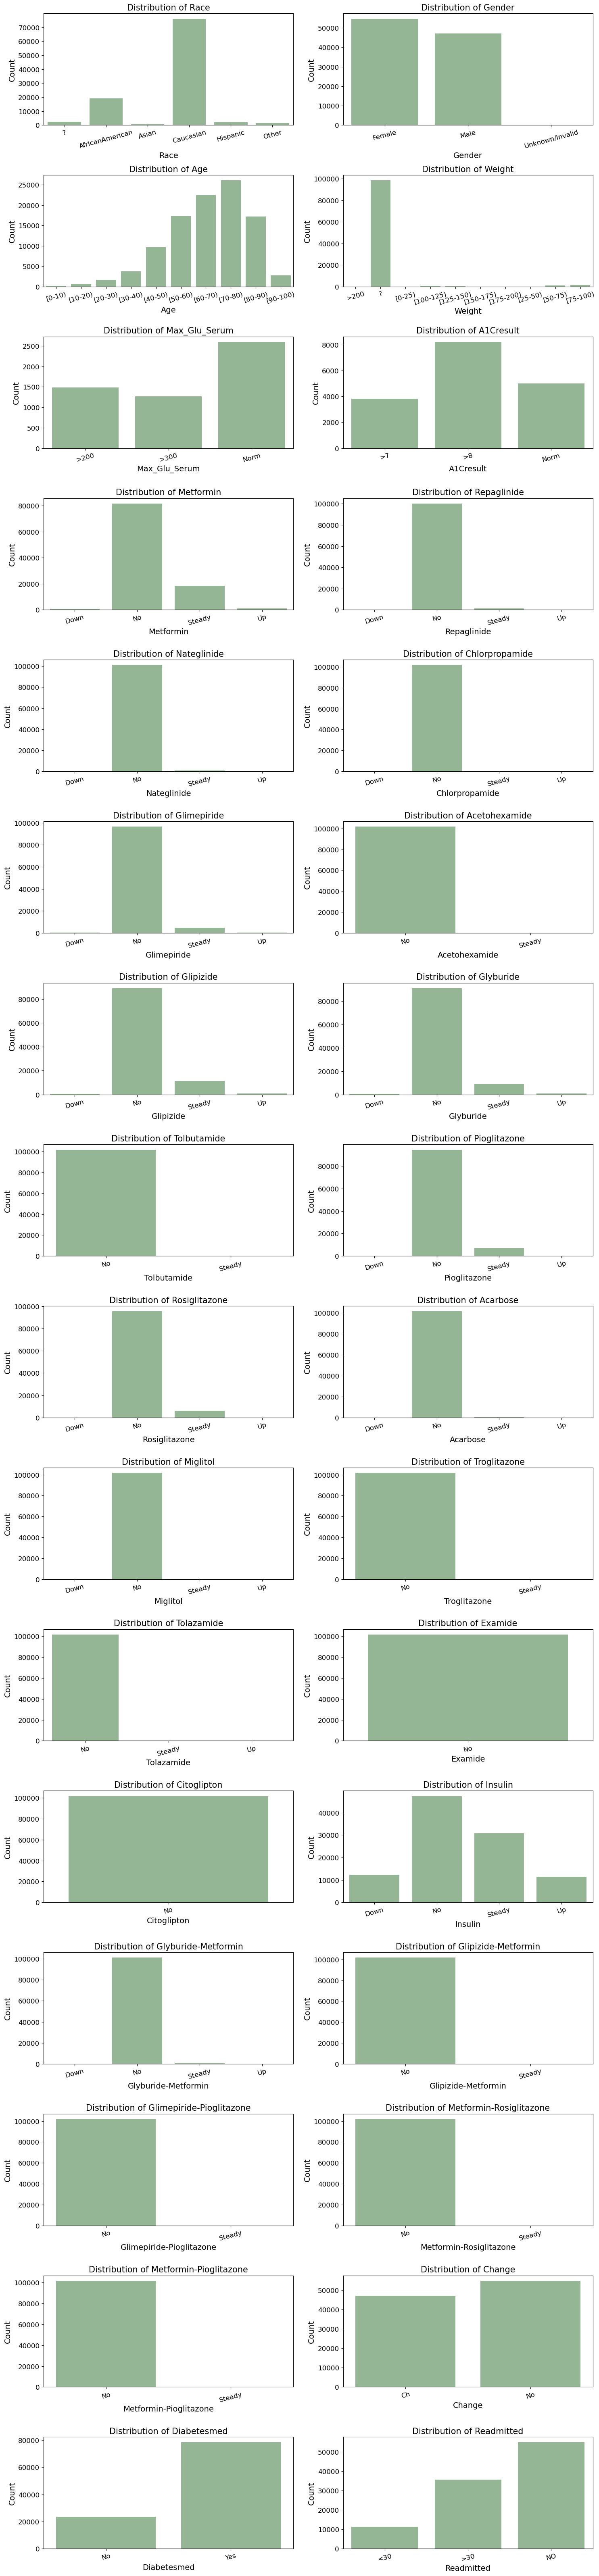

In [27]:
# try
categorical_distribution(diabetes_data)

##### **Insight**:
We used bar plot for visualizing the distribution of categorical data with total unique values less than 10. We selected this cut off since we wanted to reduce the number of features for our clustering. Based on the distribution, we planned to do the following data cleaning methods:
1. **Column removal** 
- Weight, Citoglipton, and Examide had almost uniform category. 
- Weight had "?", implying that most weights were unknown and it's impossible to impute the values based on other columns or central tendency.
- Both Citoglipton and Examide had only "No" category which meant the test results were not useful in identifying patients who have high/medium/low risk due to diabetes.
2. **Category removal/modification**
- modification: "?" in Race is converted to "Other" since we cannot specify what is the race type in "Other" group anyway. "Ch" in Change is converted to "Yes" so the data type can be binary. 
- removal: "Unknown/Invalid" in Gender is removed so we strictly analyze the relationship between two genders to diabetic risk.
3. **Data type conversion**
- we will use ordinal encoding for columns with categories: No, Down, Steady, Up (0,1,2,3). No = 0 (no medication), Down = 1 (reduced medication), Steady = 2 (same medication dose), Up = 3 (increased medication)
- for data with categories: Yes/No, we will convert to boolean type so when it's encoded there'll be no addition number of features.

4. **Cardinality reduction**
- column "age" has 10 bins which would be 10 one-hot encoded features in modeling later.
- so, we propose to reduce the cardinality by setting new bin: young (< 40 years old), middle (40< age < 60), senior (60+)


##### ii. Numerical Data Visualization

In [28]:
# show data distribution for numeric data
def numeric_distribution(df):
    num_cols = df.select_dtypes("int64","float64").columns
    
    # create plot dimension
    total_cols = 2
    total_rows = (len(num_cols) + total_cols - 1) // total_cols
    fig, axes = plt.subplots(total_rows,total_cols,figsize=(15,4*total_rows))
    axes = axes.flatten()
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3) 
    
    for i,num_col in enumerate(num_cols):
        sns.boxplot(df,x=num_col,ax=axes[i],color='lightblue')
        axes[i].set_title(f'Distribution of {num_col.title()}',fontsize=15)
        axes[i].tick_params(axis='x', rotation=15)
        axes[i].set_xlabel(num_col.title(), fontsize=13)
        axes[i].tick_params(axis='x', which='major', labelsize=12)
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.show()

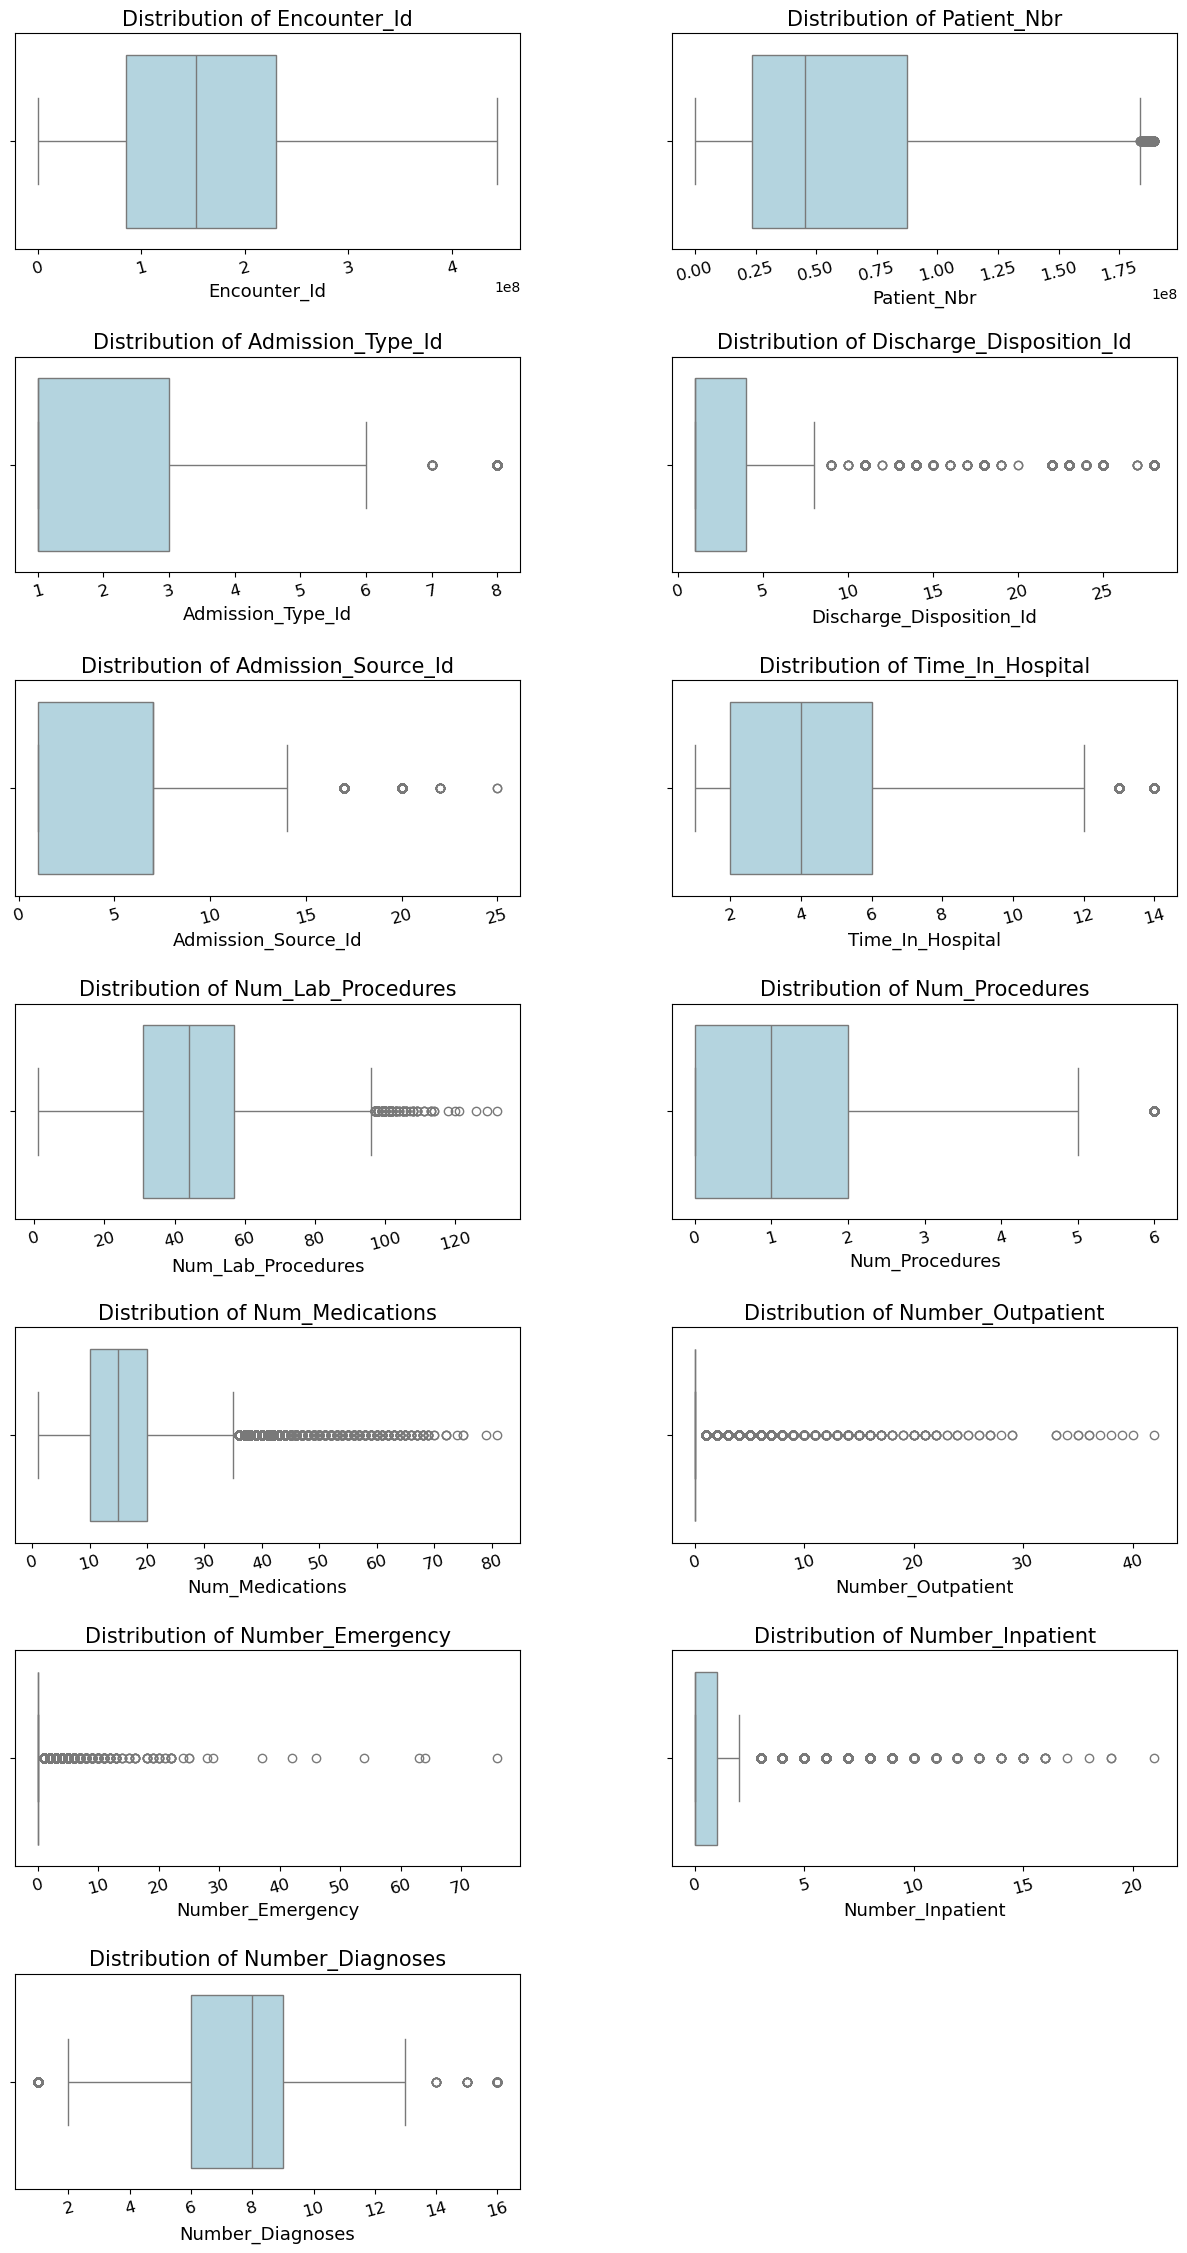

In [29]:
# show data distribution result
numeric_distribution(diabetes_data)

##### **Insight**:
Based on the data distribution and data importance, we have decided to **remove some columns**:
- **Encounter_Id, Patient_Nbr, Admission_Type_Id, Discard_Disposition_Id, Admission_Source_Id** because they are all identifier markers.
- **Number_Outpatient** and **Number_Emergency** since the data distribution were too skewed to 0 implying these features did not vary much in differentiating patients with high, medium, or low diabetic risk.


#### d. Number of Missing Values or Noisy Data

In [30]:
# create a table for showing number of missing values
# missing values are either empty or marked as "?"
processed_diabetic_data = diabetes_data.copy()
processed_diabetic_data = processed_diabetic_data.replace("?",np.nan)
processed_diabetic_data = processed_diabetic_data.replace("Unknown/Invalid",np.nan)

processed_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [31]:
# show number of missing values
missing_vals_per_col = pd.DataFrame(processed_diabetic_data.isnull().sum()).reset_index()
missing_vals_per_col = missing_vals_per_col.rename(columns={0:"total"})
missing_vals_per_col['percentage'] = round(missing_vals_per_col['total']*100/ processed_diabetic_data.shape[0],2)
missing_vals_per_col = missing_vals_per_col.sort_values(by='percentage',ascending=False)

# only get the data with missing values
mask_missing = missing_vals_per_col['total'] != 0
missing_vals_per_col[mask_missing]

,index,total,percentage
5,weight,98569,96.86
22,max_glu_serum,96420,94.75
23,A1Cresult,84748,83.28
11,medical_specialty,49949,49.08
10,payer_code,40256,39.56
2,race,2273,2.23
20,diag_3,1423,1.40
19,diag_2,358,0.35
18,diag_1,21,0.02
3,gender,3,0.00


##### **Insight**:
- Based on the percentage of missing values, we can remove data with too higher percentage values (> 10%).
- but, the paper said A1Cresult was important so we need to include it anyway and still could rely on the remaining 10K data.
- Column diag_3,diag_2, diag_1 are also excluded since the codes are hard to interpret for modeling purposes.
- therefore, we just process race data based on previous section.

### III. Data Cleaning

##### a. Column Name Filtering
- only get relevant column names, criteria:
1. non-identifier (ID-related)
2. non-sensitive demographic (race, gender)
3. non-uniform category in a column.
4. non-redundant (med pairs can be represented by individual records such as glyburide-metformin can be replaced by glyburide and metformin)

In [32]:
processed_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [33]:
# get the relevant column names
processed_diabetic_data = processed_diabetic_data.drop(columns=[
    "encounter_id",
    "patient_nbr",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "weight",
    "max_glu_serum",
    "race",
    "gender",
    # "A1Cresult",
    "medical_specialty",
    "payer_code",
    "diag_3","diag_2","diag_1","examide",'citoglipton',
    "number_outpatient","number_emergency",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone"
    ])

processed_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   age                 101766 non-null  object
 1   time_in_hospital    101766 non-null  int64 
 2   num_lab_procedures  101766 non-null  int64 
 3   num_procedures      101766 non-null  int64 
 4   num_medications     101766 non-null  int64 
 5   number_inpatient    101766 non-null  int64 
 6   number_diagnoses    101766 non-null  int64 
 7   A1Cresult           17018 non-null   object
 8   metformin           101766 non-null  object
 9   repaglinide         101766 non-null  object
 10  nateglinide         101766 non-null  object
 11  chlorpropamide      101766 non-null  object
 12  glimepiride         101766 non-null  object
 13  acetohexamide       101766 non-null  object
 14  glipizide           101766 non-null  object
 15  glyburide           101766 non-null  object
 16  to

##### b. Missing Values Handling
- Since both 'race' and 'gender' have very low percentage of missing values (< 3%), then we can safely remove the data rows.

In [113]:
# removal of missing data rows
cleaned_diabetic_data = processed_diabetic_data.dropna(axis=0).copy().reset_index(drop=True)

cleaned_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17018 entries, 0 to 17017
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 17018 non-null  object
 1   time_in_hospital    17018 non-null  int64 
 2   num_lab_procedures  17018 non-null  int64 
 3   num_procedures      17018 non-null  int64 
 4   num_medications     17018 non-null  int64 
 5   number_inpatient    17018 non-null  int64 
 6   number_diagnoses    17018 non-null  int64 
 7   A1Cresult           17018 non-null  object
 8   metformin           17018 non-null  object
 9   repaglinide         17018 non-null  object
 10  nateglinide         17018 non-null  object
 11  chlorpropamide      17018 non-null  object
 12  glimepiride         17018 non-null  object
 13  acetohexamide       17018 non-null  object
 14  glipizide           17018 non-null  object
 15  glyburide           17018 non-null  object
 16  tolbutamide         17

##### c. Change Data Type
- For 'change' and 'diabetesMed', they have binary category (yes or no). So, we can convert these first.

In [114]:
cleaned_diabetic_data.change.value_counts()

change
Ch    9490
No    7528
Name: count, dtype: int64

In [115]:
# change Ch to Yes
cleaned_diabetic_data['change'] = cleaned_diabetic_data['change'].replace('Ch','Yes')

# Convert to True False
cleanup = {'Yes': True, 'No': False}
cleaned_diabetic_data['change'] = cleaned_diabetic_data['change'].map(cleanup)
cleaned_diabetic_data['diabetesMed'] = cleaned_diabetic_data['diabetesMed'].map(cleanup)

In [116]:
cleaned_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17018 entries, 0 to 17017
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 17018 non-null  object
 1   time_in_hospital    17018 non-null  int64 
 2   num_lab_procedures  17018 non-null  int64 
 3   num_procedures      17018 non-null  int64 
 4   num_medications     17018 non-null  int64 
 5   number_inpatient    17018 non-null  int64 
 6   number_diagnoses    17018 non-null  int64 
 7   A1Cresult           17018 non-null  object
 8   metformin           17018 non-null  object
 9   repaglinide         17018 non-null  object
 10  nateglinide         17018 non-null  object
 11  chlorpropamide      17018 non-null  object
 12  glimepiride         17018 non-null  object
 13  acetohexamide       17018 non-null  object
 14  glipizide           17018 non-null  object
 15  glyburide           17018 non-null  object
 16  tolbutamide         17

##### d. Cardinality Reduction
- convert age categories from 10 -> 3 for dimensionality reduction during modeling.
- create new feature: meds_per_day which is equivalent to `df['num_medications']/df['time_in_hospital']` so we can have lessen number of features.
- change the readmitted content into binary classification:
1. < 30 and > 30 = Yes
2. No

In [ ]:
# Define mapping from original bins to new groups
age_group_mapping = {
    '[0-10)': 'young',
    '[10-20)': 'young',
    '[20-30)': 'young',
    '[30-40)': 'young',
    '[40-50)': 'middle',
    '[50-60)': 'middle',
    '[60-70)': 'senior',
    '[70-80)': 'senior',
    '[80-90)': 'senior',
    '[90-100)': 'senior'
}

# apply mapping
cleaned_diabetic_data['age_group'] = cleaned_diabetic_data['age'].map(age_group_mapping)
# drop the age column
cleaned_diabetic_data = cleaned_diabetic_data.drop(columns=['age'],axis=1)

# convert target ("readmitted") to binary classification
cleaned_diabetic_data['new_readmitted'] = np.where(cleaned_diabetic_data['readmitted'].isin(['<30', '>30']), True, False)

In [119]:
cleaned_diabetic_data['meds_per_day'] = cleaned_diabetic_data['num_medications']/cleaned_diabetic_data['time_in_hospital']

In [120]:
cleaned_diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17018 entries, 0 to 17017
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time_in_hospital    17018 non-null  int64  
 1   num_lab_procedures  17018 non-null  int64  
 2   num_procedures      17018 non-null  int64  
 3   num_medications     17018 non-null  int64  
 4   number_inpatient    17018 non-null  int64  
 5   number_diagnoses    17018 non-null  int64  
 6   A1Cresult           17018 non-null  object 
 7   metformin           17018 non-null  object 
 8   repaglinide         17018 non-null  object 
 9   nateglinide         17018 non-null  object 
 10  chlorpropamide      17018 non-null  object 
 11  glimepiride         17018 non-null  object 
 12  acetohexamide       17018 non-null  object 
 13  glipizide           17018 non-null  object 
 14  glyburide           17018 non-null  object 
 15  tolbutamide         17018 non-null  object 
 16  piog

### IV. Modeling

##### a. Data Splitting

In [48]:
# get data split
X = cleaned_diabetic_data.drop(columns=['readmitted','new_readmitted'],axis=1)
y = cleaned_diabetic_data['new_readmitted']

# First split: train + val (80%), test (20%) stratify = y to ensure all classification classes were separated well
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Further split training for GridSearchCV (25% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25,random_state=21)

##### b. Data Preprocessing

In [49]:
# find ordinal features
def find_ordinal_features(df, ordinal_values=['No', 'Down', 'Steady', 'Up']):
    ordinal_cols = []
    
    for col in df.columns:
        # Skip non-object columns (optimization)
        if not pd.api.types.is_object_dtype(df[col]):
            continue
            
        # Get unique values in the column (excluding NaN)
        unique_vals = set(df[col].dropna().unique())
        
        # Check if all values in the column are a subset of our ordinal values
        if unique_vals.issubset(ordinal_values) and len(unique_vals) > 1:
            ordinal_cols.append(col)
            
    return ordinal_cols

In [50]:
# remove uniform-content features
def uniform_feature_removal(df,col_list):
    new_list = []
    for col in col_list:
        if df[col].nunique() == 1:
            print(f"{col} has only one unique value, must be removed")
        else:
            new_list.append(col)
    return new_list

In [51]:
# get column names
categorical_features = X_train.select_dtypes('object').columns
# get the features separately for processing differently
ordinal_features = find_ordinal_features(X_train)
ordinal_features_2 = find_ordinal_features(X_train,['young','middle','senior'])
bool_features = X_train.select_dtypes('bool').columns
# Other categorical features (non-ordinal, non-bool)
other_cat_features = [
    col for col in categorical_features 
    if col not in ordinal_features and col not in bool_features and col not in ordinal_features_2
]
numeric_features = X_train.select_dtypes(['int64','float']).columns

In [52]:
# get the features separately for processing differently
new_ordinal_features = uniform_feature_removal(X_train,ordinal_features)
new_ordinal_features_2 = uniform_feature_removal(X_train,ordinal_features_2)
bool_features = X_train.select_dtypes('bool').columns
# Other categorical features (non-ordinal, non-bool)
new_other_cat_features = uniform_feature_removal(X_train,other_cat_features)

acetohexamide has only one unique value, must be removed
troglitazone has only one unique value, must be removed


In [53]:
# remove the column above on test set
X_train = X_train.drop(columns=['troglitazone','acetohexamide'],axis=1)
print(f"Train columns: {X_train.columns}")
X_val = X_val.drop(columns=['troglitazone','acetohexamide'],axis=1)
print(f"Val columns: {X_val.columns}")
X_test = X_test.drop(columns=['troglitazone','acetohexamide'],axis=1)
print(f"Test columns: {X_test.columns}")

Train columns: Index(['num_lab_procedures', 'num_procedures', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'tolazamide', 'insulin', 'change', 'diabetesMed',
       'age_group', 'meds_per_day'],
      dtype='object')
Val columns: Index(['num_lab_procedures', 'num_procedures', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'tolazamide', 'insulin', 'change', 'diabetesMed',
       'age_group', 'meds_per_day'],
      dtype='object')
Test columns: Index(['num_lab_procedures', 'num_procedures', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide',
 

In [54]:
# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['No','Down','Steady','Up']] * len(new_ordinal_features)), new_ordinal_features),
        ('ordinal_2', OrdinalEncoder(categories=[['young','middle','senior']] * len(new_ordinal_features_2)), new_ordinal_features_2),
        ('bool', 'passthrough', bool_features),  # Already encoded as 0/1
        ('onehot', OneHotEncoder(handle_unknown='ignore',min_frequency=0.05), new_other_cat_features),
        ('numeric', RobustScaler(), numeric_features)
    ],
    remainder='drop'  # Drops unspecified columns
)

In [55]:
# 1. Fit the preprocessor first
preprocessor.fit(X_train)

# 2. Convert all feature lists to standard Python lists
# new_ordinal_features = list(new_ordinal_features)
new_ordinal_features_2 = list(new_ordinal_features_2)
bool_features = list(bool_features) 
numeric_features = list(numeric_features)

# 3. Get one-hot feature names
onehot_transformer = preprocessor.named_transformers_['onehot']
onehot_columns = list(onehot_transformer.get_feature_names_out(new_other_cat_features))

# 4. Combine all feature names
feature_names = (
    new_ordinal_features +
    new_ordinal_features_2 +
    bool_features + 
    onehot_columns +
    numeric_features
)

# 5. Create final DataFrame
X_train_df = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=feature_names
)

In [67]:
X_train_df

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,...,change,diabetesMed,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,num_lab_procedures,num_procedures,number_inpatient,number_diagnoses,meds_per_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,-0.476190,0.0,0.0,-0.333333,2.094545
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,-1.571429,0.5,0.0,0.000000,0.130909
2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.238095,1.0,0.0,-1.333333,-0.032727
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.666667,0.0,0.0,0.000000,1.003636
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.571429,1.5,0.0,-1.000000,-0.305455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10205,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.238095,0.0,0.0,-1.666667,0.676364
10206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.761905,1.0,0.0,-1.333333,1.276364
10207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,-0.380952,1.5,3.0,-0.333333,-0.720000
10208,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,-2.142857,0.0,0.0,-0.666667,4.058182


In [57]:
# resulting data processing
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10210 entries, 0 to 10209
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   metformin           10210 non-null  float64
 1   repaglinide         10210 non-null  float64
 2   nateglinide         10210 non-null  float64
 3   chlorpropamide      10210 non-null  float64
 4   glimepiride         10210 non-null  float64
 5   glipizide           10210 non-null  float64
 6   glyburide           10210 non-null  float64
 7   tolbutamide         10210 non-null  float64
 8   pioglitazone        10210 non-null  float64
 9   rosiglitazone       10210 non-null  float64
 10  acarbose            10210 non-null  float64
 11  miglitol            10210 non-null  float64
 12  tolazamide          10210 non-null  float64
 13  insulin             10210 non-null  float64
 14  age_group           10210 non-null  float64
 15  change              10210 non-null  float64
 16  diab

In [58]:
# get transformed X_train and X_test
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [59]:
# 5. Create final DataFrame
X_val_df = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=feature_names
)

In [60]:
# 5. Create final DataFrame
X_test_df = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names
)

##### c. Final Feature Selection

In [100]:
selector = SelectKBest(f_classif, k=20)
final_X_train_df = selector.fit_transform(X_train_df, y_train)
selected_features = X_train_df.columns[selector.get_support()]
print("Optimal features:", selected_features)

Optimal features: Index(['metformin', 'repaglinide', 'glimepiride', 'glipizide', 'tolbutamide',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'age_group', 'change', 'diabetesMed', 'A1Cresult_>8', 'A1Cresult_Norm',
       'num_lab_procedures', 'num_procedures', 'number_inpatient',
       'number_diagnoses', 'meds_per_day'],
      dtype='object')


In [101]:
# apply same column selections
final_X_val_df = X_val_df[selected_features]
final_X_test_df = X_test_df[selected_features]

##### c. Model Training

In [102]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
# param_grid = {
#     'penalty': ['l2'],           # Ridge regularization (default)
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength
#     'solver': ['lbfgs', 'liblinear'],
#     'class_weight': [None, 'balanced']
# }

param_grid = {
    'penalty': ['l2'],  # Test L1/L2 mix
    'C': [0.001, 0.01, 0.1, 1, 10, 100],      # 20 values from 0.001 to 1000
    'solver': ['lbfgs', 'liblinear'],               # Only solver supporting elasticnet
    # 'l1_ratio': [0, 0.25, 0.5, 0.75, 1],  # Mix of L1/L2
    'class_weight': [
        None,
        'balanced',{False: 1, True: 3}]
}

log_cv = GridSearchCV(
    log_model,
    param_grid,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1
)
log_cv.fit(final_X_train_df, y_train)

print(f"Best params: {log_cv.best_params_}")
print(f"Best score: {log_cv.best_score_:.3f}")

Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.608


In [103]:
# Random Forest
rf_model = RandomForestClassifier(
    random_state=21
    # class_weight={'NO':15, '>30':25, '<30':40}
)
param_grid = {
    'n_estimators': [300,400,500],
    'max_depth': [8, 10,12],
    'min_samples_split': [2, 5],   
    'class_weight': ['balanced',{False: 1, True: 3}],
    'criterion':['gini']
}

rf_grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1
)
rf_grid_search.fit(final_X_train_df, y_train)
print(f"Best params: {rf_grid_search.best_params_}")
print(f"Best score: {rf_grid_search.best_score_:.3f}")

Best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 400}
Best score: 0.613


In [104]:
dummy = DummyClassifier(strategy='stratified').fit(X_train_transformed, y_train)
print("Baseline F1:", dummy.score(X_test_transformed, y_test))

Baseline F1: 0.5352526439482961


In [105]:
# Logistic Regression
svm_model = SVC(random_state = 21)

param_grid = {
    'C': [0.5, 1, 2],  # regularization strength
    'kernel': ['rbf'],            # kernel type
    'gamma': ['scale', 0.005,0.01],  # kernel coefficient
    'class_weight': [
        'balanced',
        {False: 1, True: 3}
    ]}

svm_cv = GridSearchCV(
    svm_model,
    param_grid,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1
)
svm_cv.fit(final_X_train_df, y_train)

print(f"Best params: {svm_cv.best_params_}")
print(f"Best score: {svm_cv.best_score_:.3f}")

Best params: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.611


##### d. Model Evaluation

Training Performance:
               precision    recall  f1-score   support

       False       0.65      0.68      0.67      1924
        True       0.56      0.54      0.55      1480

    accuracy                           0.62      3404
   macro avg       0.61      0.61      0.61      3404
weighted avg       0.61      0.62      0.61      3404



/Users/catherinemulyadi/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


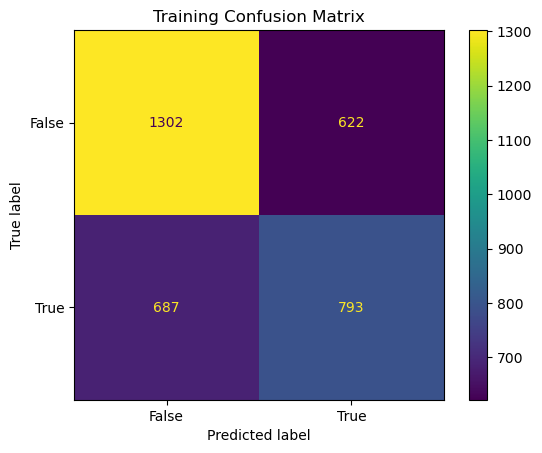

In [109]:
# Get the best model from GridSearchCV
best_log = log_cv.best_estimator_

# Generate predictions on test data (or validation data)
y_val_log_pred = best_log.predict(final_X_val_df)  # Use your transformed test set

# 1. Classification Report
print("Training Performance:\n", classification_report(y_val, y_val_log_pred))

# 2. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_log_pred)
plt.title("Training Confusion Matrix")
plt.show()

Training Performance:
               precision    recall  f1-score   support

       False       0.66      0.70      0.68      1924
        True       0.57      0.53      0.55      1480

    accuracy                           0.62      3404
   macro avg       0.62      0.61      0.61      3404
weighted avg       0.62      0.62      0.62      3404



/Users/catherinemulyadi/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


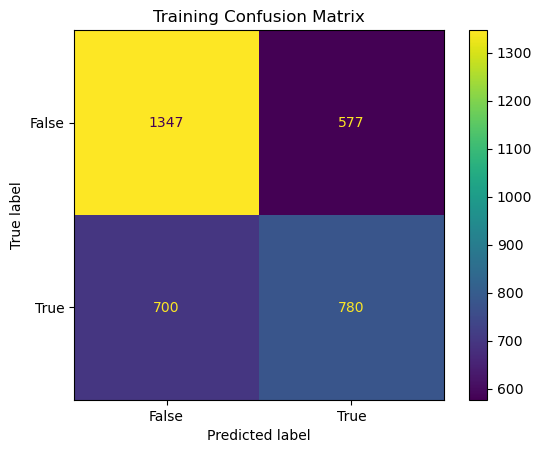

In [110]:
# Get the best model from GridSearchCV
best_rf = rf_grid_search.best_estimator_

# Generate predictions on test data (or validation data)
y_val_rf_pred = best_rf.predict(final_X_val_df)  # Use your transformed test set

# 1. Classification Report
print("Training Performance:\n", classification_report(y_val, y_val_rf_pred))

# 2. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_rf_pred)
plt.title("Training Confusion Matrix")
plt.show()

/Users/catherinemulyadi/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Training Performance:
               precision    recall  f1-score   support

       False       0.65      0.72      0.68      1924
        True       0.58      0.50      0.54      1480

    accuracy                           0.62      3404
   macro avg       0.62      0.61      0.61      3404
weighted avg       0.62      0.62      0.62      3404



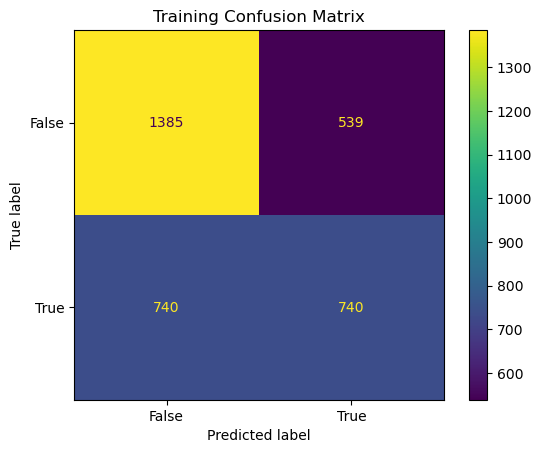

In [111]:
# Get the best model from GridSearchCV
best_svm = svm_cv.best_estimator_

# Generate predictions on test data (or validation data)
y_val_svm_pred = best_svm.predict(final_X_val_df)  # Use your transformed test set

# 1. Classification Report
print("Training Performance:\n", classification_report(y_val, y_val_svm_pred))

# 2. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_svm_pred)
plt.title("Training Confusion Matrix")
plt.show()

##### Insight:

the best overall performing model is logistic regression since it still has good f-1 score (> 50%) with higher recall for readmitted patient instances (54%). In other words, the number of misclassification for readmitted patient is least compared to other models which is important in our application.